# Requirements

In [2]:
%pip install pandas numpy matplotlib seaborn 
%pip install scikit-learn
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import kstest, kruskal, norm
from sklearn.decomposition import PCA
import statsmodels.api as sm
from plotly.subplots import make_subplots
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import mahalanobis
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

### Data

- Definição das funções

In [33]:
DATA_PATH = 'PhiUSIIL_Phishing_URL_Dataset.csv'

def load_data(data_path=DATA_PATH):
    data = pd.read_csv(data_path)
    
    print("\nInformações do Dataset:")
    display(data.info())
    
    print("\nPrimeiras linhas do Dataset:")
    display(data.head(10))
    
    print("\nEstatísticas do Dataset:")
    display(data.describe())
    
    print("\nValores nulos no Dataset:")
    display(data.isnull().sum())
    
    # Modificar a coluna label para target, para ser de fácil perceção 
    data.rename(columns={'label': 'target'}, inplace=True)
    
    # Remover colunas categóricas
    categorical_columns = data.select_dtypes(include=['object']).columns
    data.drop(categorical_columns, axis=1, inplace=True)
    
    # Remover variáveis binárias excepto o target (label)
    binary_columns = [col for col in data.columns if data[col].nunique() == 2 and col != 'target']
    data.drop(binary_columns, axis=1, inplace=True)
    
    #Vai apresentar o nome das colunas
    #display("Columns: " + ", ".join(list(map(str, data.columns))))
    
    return data

In [34]:
def separar_features_target(data):
    X = data.copy()
    X.drop('target', axis=1,inplace=True)
    y = data['target'].copy()
    
    return X,y

#### Nota: Imagina temos muiats features binárias será que queremos normalizar essas?
No que toca a remoção de features não é possiel usar o Anova test, uma vez que elas não seguem uma distribuição normal como vamos ver mais abaixo 

In [35]:
def normalizar_features(X):
    
    scaler = StandardScaler() # É o mesmo que usar Z_score, pois a média é 0 e o desvio padrão é 1
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X

- Execução Pré - Processamento

- Análise dos dados

  - 1 - Legítimo | 0 - Phishing


  Podemos excluir features com correlação muito alta, pois podem ser redundantes (acima de 90%)

In [36]:
def plot_class_distribution(data):
    
    values = data['target'].value_counts()
    keys = ['Legítimo', 'Phishing']
    
    fig_pie = px.pie(names=keys, values=values, title='Class Distribution (%)')
    
    fig_bar = px.bar(x=keys, y=values, labels={'x': 'Class', 'y': 'Count'},
                     title="Class Distribution (Phishing vs. Legitimate)")
    
    fig_pie.show()
    fig_bar.show()
    
    print("\nPerc. of class 1 (Legítimo): " + str(data['target'].sum() / data.shape[0] * 100) + " %")

    corr_matrix = data.corr()

    threshold = 0.9

    features_to_drop = set()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                features_to_drop.add(colname)

    # Remover as features correlacionadas
    data_reduced = data.drop(columns=features_to_drop)

    plt.figure(figsize=(40, 40))
    sns.heatmap(data_reduced.corr(), annot=True, cmap='mako', vmin=-1.0)
    plt.title("Correlation Matrix (After Removal)")
    plt.show()

    print(f"Removed features: {features_to_drop}")

    
    


In [8]:
def boxplot_features(df, target):
    # Substituir os valores 0 e 1 por 'Phishing' e 'Legitimate'
    df[target] = df[target].replace({0: 'Phishing', 1: 'Legitimate'})
    
    num_features = df.drop(columns=[target]).select_dtypes(include=['number']).columns  # Apenas features numéricas
    num_cols = 5  
    num_rows = 12  

    plt.figure(figsize=(num_cols * 5, num_rows * 5))  

    for i, feature in enumerate(num_features):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.boxplot(x=target, y=feature, data=df, hue=target, palette="coolwarm", dodge=False, legend=False)
        plt.title(f"Boxplot of {feature}")
        plt.xlabel(target)
        plt.ylabel(feature)

    plt.tight_layout()
    plt.show()



Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  in

None


Primeiras linhas do Dataset:


FILENAME                                 URL  URLLength  \
0  521848.txt    https://www.southbankmosaics.com         31   
1   31372.txt            https://www.uni-mainz.de         23   
2  597387.txt      https://www.voicefmradio.co.uk         29   
3  554095.txt         https://www.sfnmjournal.com         26   
4  151578.txt  https://www.rewildingargentina.org         33   
5   23107.txt     https://www.globalreporting.org         30   
6   23034.txt          https://www.saffronart.com         25   
7  696732.txt          https://www.nerdscandy.com         25   
8  739255.txt      https://www.hyderabadonline.in         29   
9   14486.txt                 https://www.aap.org         18   

                       Domain  DomainLength  IsDomainIP  TLD  \
0    www.southbankmosaics.com            24           0  com   
1            www.uni-mainz.de            16           0   de   
2      www.voicefmradio.co.uk            22           0   uk   
3         www.sfnmjournal.com            19           0  com   
4  www.rewildingargentina.org            26           0  org   
5     www.globalreporting.org            23           0  org   
6          www.saffronart.com            18           0  com   
7          www.nerdscandy.com            18           0  com   
8      www.hyderabadonline.in            22           0   in   
9                 www.aap.org            11           0  org   

   URLSimilarityIndex  CharContinuationRate  TLDLegitimateProb  ...  Pay  \
0               100.0              1.000000           0.522907  ...    0   
1               100.0              0.666667           0.032650  ...    0   
2               100.0              0.866667           0.028555  ...    0   
3               100.0              1.000000           0.522907  ...    1   
4               100.0              1.000000           0.079963  ...    1   
5               100.0              1.000000           0.079963  ...    0   
6               100.0              1.000000           0.522907  ...    0   
7               100.0              1.000000           0.522907  ...    0   
8               100.0              1.000000           0.005084  ...    0   
9               100.0              1.000000           0.079963  ...    0   

   Crypto  HasCopyrightInfo  NoOfImage  NoOfCSS  NoOfJS  NoOfSelfRef  \
0       0                 1         34       20      28          119   
1       0                 1         50        9       8           39   
2       0                 1         10        2       7           42   
3       1                 1          3       27      15           22   
4       0                 1        244       15      34           72   
5       0                 1         35        1      11           86   
6       0                 1         32        4      14           44   
7       0                 1         24        2      22           36   
8       0                 1         71        4       9           40   
9       0                 1         10        1      12          173   

   NoOfEmptyRef  NoOfExternalRef  label  
0             0              124      1  
1             0              217      1  
2             2                5      1  
3             1               31      1  
4             1               85      1  
5             0               14      1  
6             2               17      1  
7             0               15      1  
8             1              317      1  
9             6               65      1  

[10 rows x 56 columns]


Estatísticas do Dataset:


URLLength   DomainLength     IsDomainIP  URLSimilarityIndex  \
count  235795.000000  235795.000000  235795.000000       235795.000000   
mean       34.573095      21.470396       0.002706           78.430778   
std        41.314153       9.150793       0.051946           28.976055   
min        13.000000       4.000000       0.000000            0.155574   
25%        23.000000      16.000000       0.000000           57.024793   
50%        27.000000      20.000000       0.000000          100.000000   
75%        34.000000      24.000000       0.000000          100.000000   
max      6097.000000     110.000000       1.000000          100.000000   

       CharContinuationRate  TLDLegitimateProb    URLCharProb      TLDLength  \
count         235795.000000      235795.000000  235795.000000  235795.000000   
mean               0.845508           0.260423       0.055747       2.764456   
std                0.216632           0.251628       0.010587       0.599739   
min                0.000000           0.000000       0.001083       2.000000   
25%                0.680000           0.005977       0.050747       2.000000   
50%                1.000000           0.079963       0.057970       3.000000   
75%                1.000000           0.522907       0.062875       3.000000   
max                1.000000           0.522907       0.090824      13.000000   

       NoOfSubDomain  HasObfuscation  ...            Pay         Crypto  \
count  235795.000000   235795.000000  ...  235795.000000  235795.000000   
mean        1.164758        0.002057  ...       0.237007       0.023474   
std         0.600969        0.045306  ...       0.425247       0.151403   
min         0.000000        0.000000  ...       0.000000       0.000000   
25%         1.000000        0.000000  ...       0.000000       0.000000   
50%         1.000000        0.000000  ...       0.000000       0.000000   
75%         1.000000        0.000000  ...       0.000000       0.000000   
max        10.000000        1.000000  ...       1.000000       1.000000   

       HasCopyrightInfo      NoOfImage        NoOfCSS         NoOfJS  \
count     235795.000000  235795.000000  235795.000000  235795.000000   
mean           0.486775      26.075689       6.333111      10.522305   
std            0.499826      79.411815      74.866296      22.312192   
min            0.000000       0.000000       0.000000       0.000000   
25%            0.000000       0.000000       0.000000       0.000000   
50%            0.000000       8.000000       2.000000       6.000000   
75%            1.000000      29.000000       8.000000      15.000000   
max            1.000000    8956.000000   35820.000000    6957.000000   

         NoOfSelfRef   NoOfEmptyRef  NoOfExternalRef          label  
count  235795.000000  235795.000000    235795.000000  235795.000000  
mean       65.071113       2.377629        49.262516       0.571895  
std       176.687539      17.641097       161.027430       0.494805  
min         0.000000       0.000000         0.000000       0.000000  
25%         0.000000       0.000000         1.000000       0.000000  
50%        12.000000       0.000000        10.000000       1.000000  
75%        88.000000       1.000000        57.000000       1.000000  
max     27397.000000    4887.000000     27516.000000       1.000000  

[8 rows x 51 columns]


Valores nulos no Dataset:


FILENAME                      0
URL                           0
URLLength                     0
Domain                        0
DomainLength                  0
IsDomainIP                    0
TLD                           0
URLSimilarityIndex            0
CharContinuationRate          0
TLDLegitimateProb             0
URLCharProb                   0
TLDLength                     0
NoOfSubDomain                 0
HasObfuscation                0
NoOfObfuscatedChar            0
ObfuscationRatio              0
NoOfLettersInURL              0
LetterRatioInURL              0
NoOfDegitsInURL               0
DegitRatioInURL               0
NoOfEqualsInURL               0
NoOfQMarkInURL                0
NoOfAmpersandInURL            0
NoOfOtherSpecialCharsInURL    0
SpacialCharRatioInURL         0
IsHTTPS                       0
LineOfCode                    0
LargestLineLength             0
HasTitle                      0
Title                         0
DomainTitleMatchScore         0
URLTitle


Perc. of class 1 (Legítimo): 57.189507835195826 %


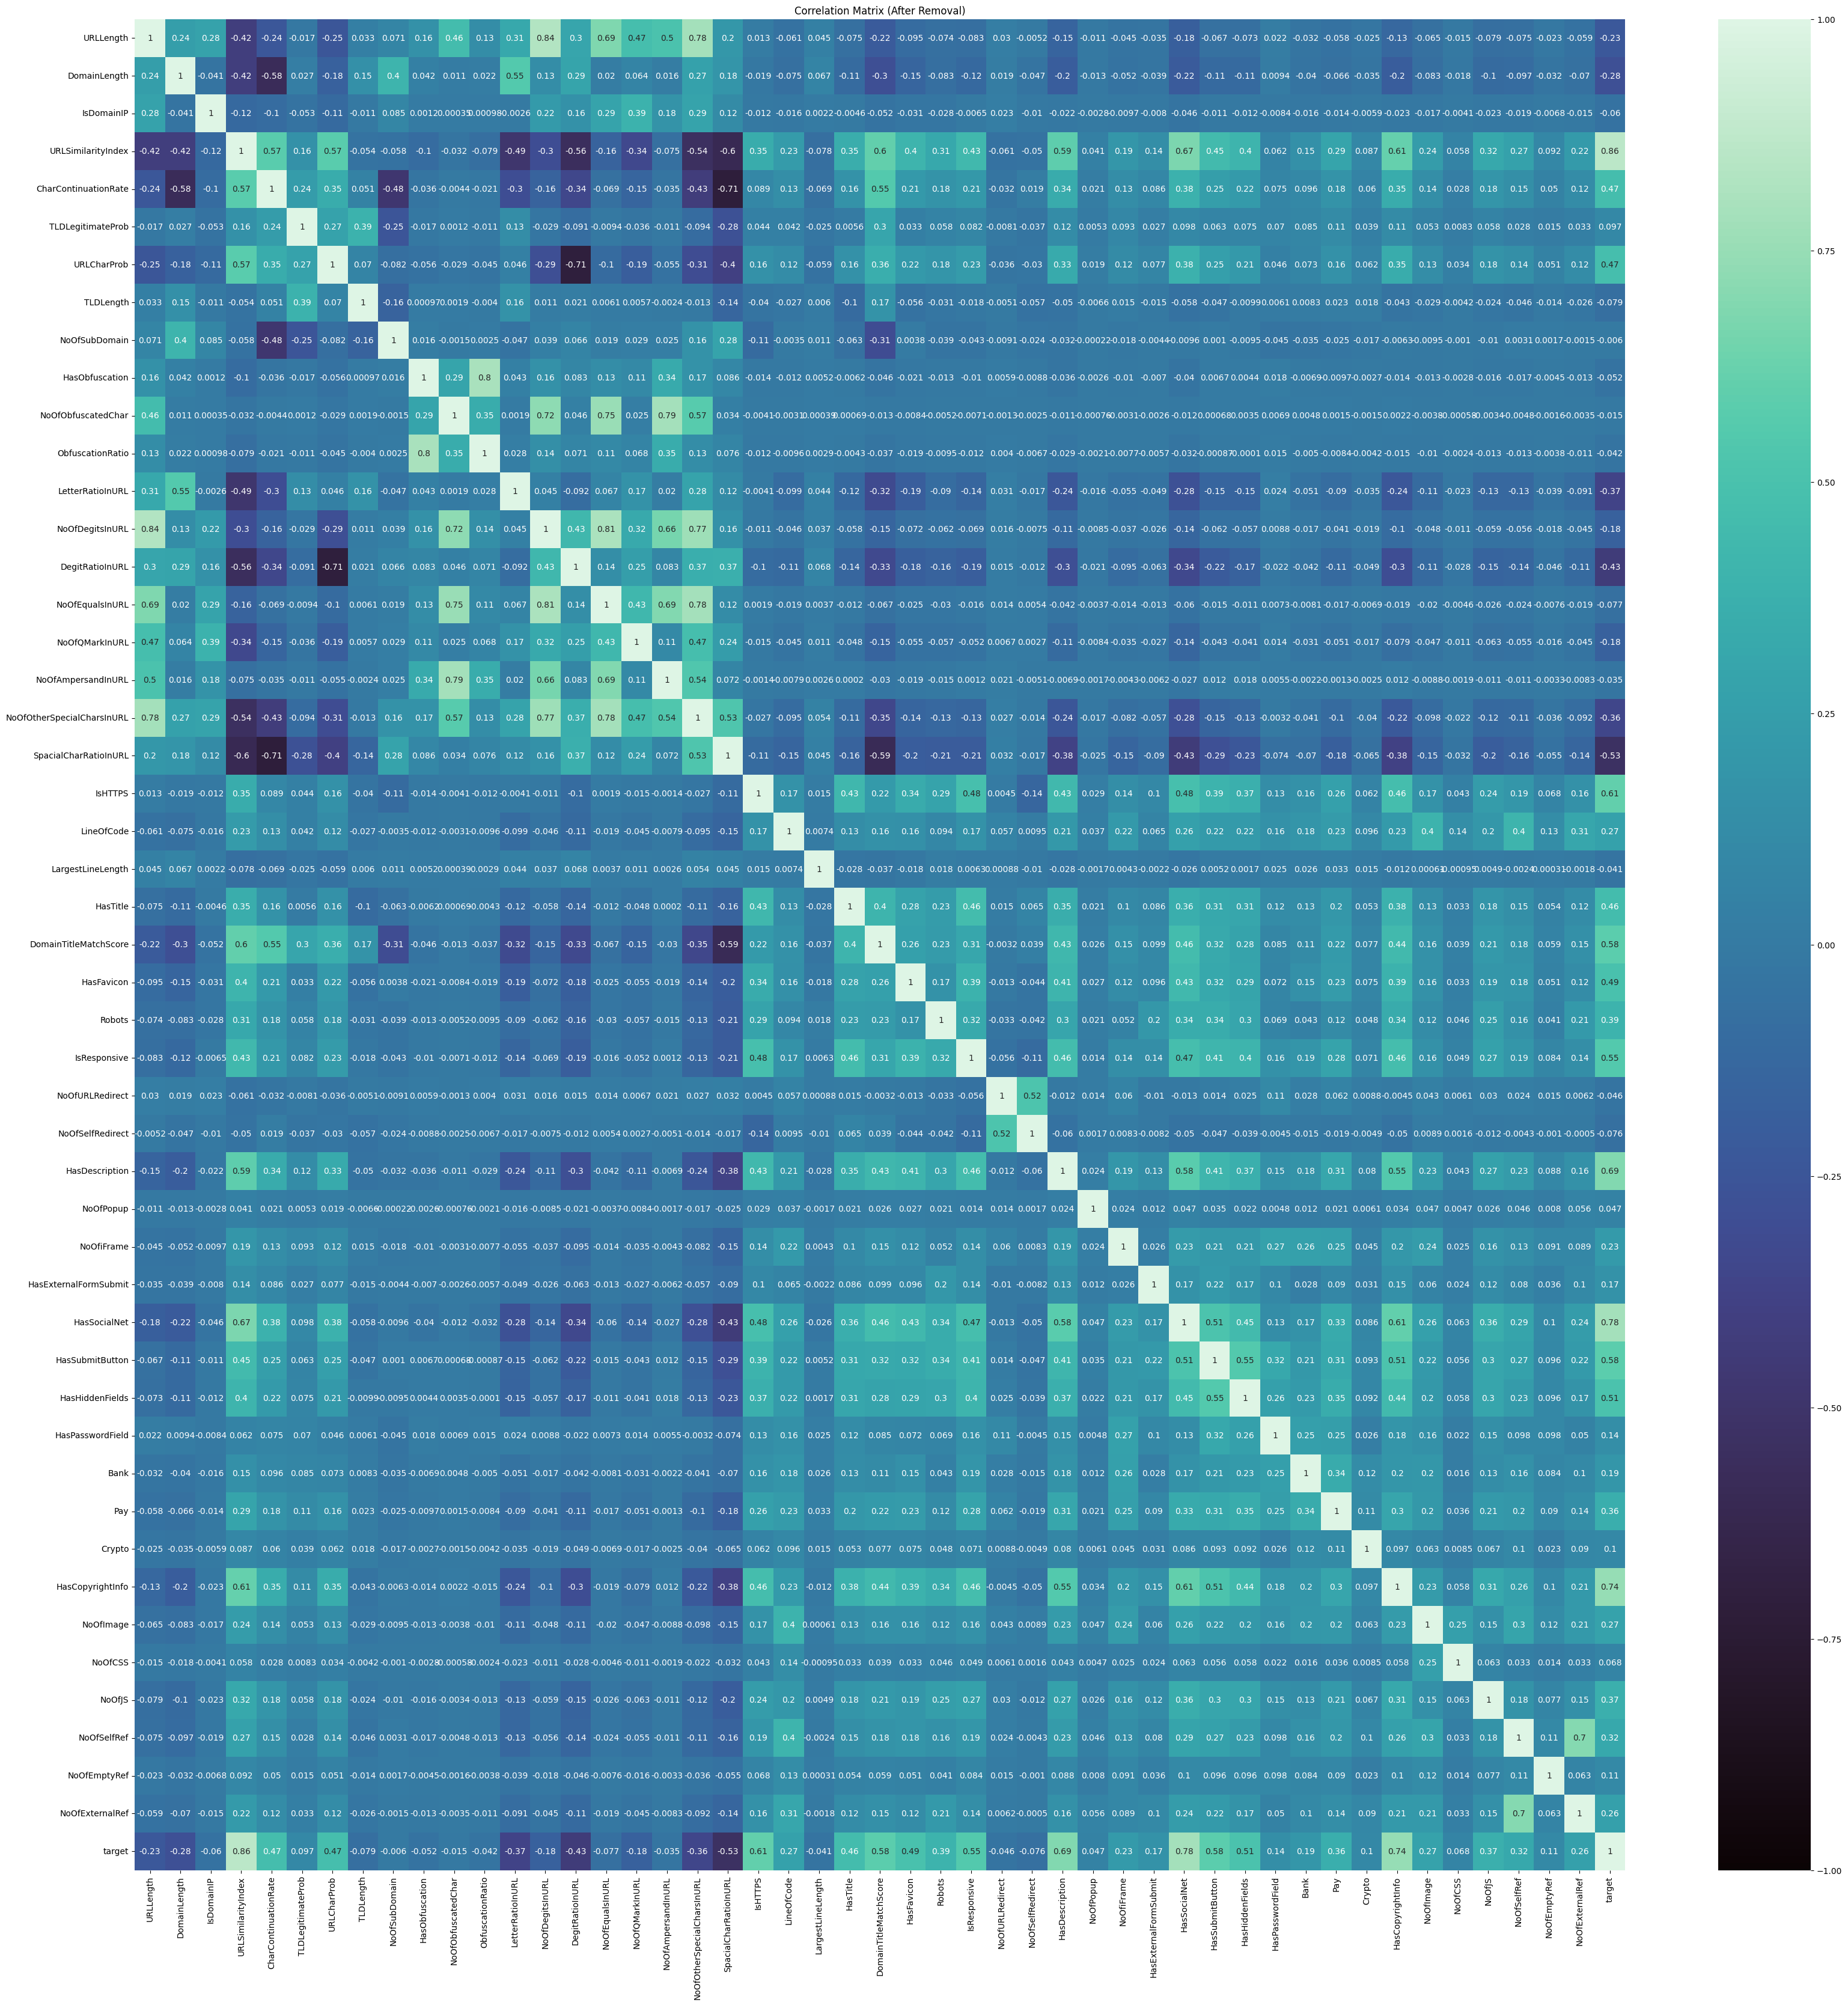

Removed features: {'URLTitleMatchScore', 'NoOfLettersInURL'}


In [9]:

data = load_data()
plot_class_distribution(data)
#boxplot_features(data, "target")
X, y = separar_features_target(data)
X = normalizar_features(X)


### Kolmogorov-Smirnov Test

1️⃣ Primeiro, usamos KS-Test no dataset completo para decidir se as features são normalmente distribuídas.

2️⃣ Depois, usamos KS-Test separado por target para verificar se as distribuições variam entre phishing e legítimo.

3️⃣ Se houver uma diferença grande entre classes, a feature pode ser relevante para classificação.

É de realçar que todas as features seguem uma distribuição não normal, tanto para KS-Test no dataset completo, como para o KS-Test separado por target 

In [23]:

def KS_Test(X, y, features, alpha=0.05):
    
    #Separar por target e verificar se segue uma distribuição normal
    normal_features_target = {}
    non_normal_features_target = {}
    for f in features:
        for cls in [0, 1]:  # 1 = Legítimo, 0 = Phishing
            class_data = X[y == cls][f]
            class_data = (class_data - class_data.mean()) / class_data.std()  # Normalização Z-score
            
            ks_stat, p_value = kstest(class_data, 'norm')
            #print(f"Feature: {f}, Classe: {cls}, KS Statistic: {ks_stat}, p-value: {p_value}")
            if p_value > alpha:
                normal_features_target[f] = cls
            else:
                non_normal_features_target[f] = cls
                     
            
    #Sem separar por target
    ks_statistic = []
    p_value = []
    
    normal_features = []
    non_normal_features = []
    i = 0
    
    for feature in features:
        
        featV = X[feature]
            
        if i == 0: # Plotar apenas para a primeira feature, podemos so mudar o valor de i para plotar a feature que queremos
            
            fig = make_subplots(rows=1, cols=2, subplot_titles=("CDF vs ECDF", "PDF vs EPDF"))

            # Add histogram/EPDF
            fig.add_trace(go.Histogram(x=featV, nbinsx=20, histnorm='probability density', name="EPDF"), row=1, col=2)

            # Generate data for the normal distribution
            mu = 0  # Mean
            sigma = 1  # Standard Deviation
            x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
            pdf = norm.pdf(x, mu, sigma)
            cdf = norm.cdf(x, mu, sigma)

            # Add pdf to the histogram figure
            fig.add_trace(go.Scatter(x=x, y=pdf, mode='lines', name="PDF"), row=1, col=2)

            # Plot theoretical and empirical CDF
            ecdf = sm.distributions.ECDF(featV)
            xs = np.linspace(min(featV), max(featV))
            ecdfs = ecdf(xs)
            fig.add_trace(go.Scatter(x=xs, y=ecdfs, mode='lines', name="ECDF"), row=1, col=1)
            fig.add_trace(go.Scatter(x=x, y=cdf, mode='lines', name="CDF"), row=1, col=1)

            # Update xaxis properties
            fig.update_xaxes(title_text=feature, row=1, col=1)
            fig.update_xaxes(title_text=feature, row=1, col=2)
            fig.update_yaxes(title_text="CDF/ECDF", row=1, col=1)
            fig.update_yaxes(title_text="PDF/EPDF", row=1, col=2)
            fig.update_layout(autosize=False, width=1200, height=600, font=dict(size=18, color="black"))
            fig.show()
            
        i += 1
        
        ks, pvalue =kstest(featV,norm.cdf)
        ks_statistic.append(ks)
        p_value.append(pvalue)
        if pvalue>alpha:
            normal_features.append(feature)
        else:
            non_normal_features.append(feature)
                
    print(ks_statistic)
    print(p_value)
    
    return normal_features, non_normal_features
                
            
normal_features, non_normal_features = KS_Test(X, y, X.columns)
# Nenhuma feature segue uma distribuição normal (p-value < 0.05)
print("Features Normal Distribution : ", normal_features)
print("Features Non Normal Distribution: ", non_normal_features)


[np.float64(0.3326579436282317), np.float64(0.14617068147506707), np.float64(0.5180646715843042), np.float64(0.3469059283574893), np.float64(0.3557121531773409), np.float64(0.32889775918299935), np.float64(0.10157143172322314), np.float64(0.35901195217697957), np.float64(0.4239330551960097), np.float64(0.516048672454196), np.float64(0.5032290289023071), np.float64(0.5124074674404608), np.float64(0.29623437011727843), np.float64(0.03289504477653288), np.float64(0.4371317100866975), np.float64(0.4385126579069989), np.float64(0.503639899308149), np.float64(0.5343887888694959), np.float64(0.5081867534697353), np.float64(0.35198609136362907), np.float64(0.18056482805758783), np.float64(0.48353538376119176), np.float64(0.3694502391016015), np.float64(0.46657348758766704), np.float64(0.5171826439333351), np.float64(0.3281521240361195), np.float64(0.3332980962474208), np.float64(0.4124711850989955), np.float64(0.4601478249700234), np.float64(0.4054617217560234), np.float64(0.5191843301241965),

### Kruskal Wallis Test

In [11]:

def KW_test(X, features):
    Hs = {}
    
    ix_legitimo = np.where(y == 1)[0]
    ix_phishing = np.where(y == 0)[0]
   
    for i in range(X.shape[1]):
        stat = kruskal(X.iloc[ix_legitimo, i], X.iloc[ix_phishing, i]) # iloc trabalha com pandas, flatten trabalha com numpy
        Hs[features[i]] = stat  
 
    Hs_sorted = sorted(Hs.items(), key=lambda x: x[1], reverse=True)
    
    return Hs_sorted



Hs_sorted = KW_test(X, X.columns)
print(Hs_sorted)
    

[('URLSimilarityIndex', KruskalResult(statistic=np.float64(210584.39036357813), pvalue=np.float64(0.0))), ('NoOfExternalRef', KruskalResult(statistic=np.float64(167404.03123554974), pvalue=np.float64(0.0))), ('NoOfImage', KruskalResult(statistic=np.float64(167374.10572427587), pvalue=np.float64(0.0))), ('LineOfCode', KruskalResult(statistic=np.float64(166758.99813854924), pvalue=np.float64(0.0))), ('NoOfSelfRef', KruskalResult(statistic=np.float64(162123.57914756692), pvalue=np.float64(0.0))), ('NoOfJS', KruskalResult(statistic=np.float64(159715.89402412856), pvalue=np.float64(0.0))), ('NoOfCSS', KruskalResult(statistic=np.float64(152179.26990352495), pvalue=np.float64(0.0))), ('HasSocialNet', KruskalResult(statistic=np.float64(145026.30894476114), pvalue=np.float64(0.0))), ('HasCopyrightInfo', KruskalResult(statistic=np.float64(130295.14068741896), pvalue=np.float64(0.0))), ('HasDescription', KruskalResult(statistic=np.float64(112336.95754768897), pvalue=np.float64(0.0))), ('NoOfOther

In [12]:

def plot_features(X, y, top_features):
    data = X.copy()
    data['Class'] = y.map({0: 'Phishing', 1: 'Legítimo'})
    
    color_discrete_map = {'Legítimo': 'lightskyblue', 'Phishing': 'hotpink'}
    
    for feature in top_features:
        fig = go.Figure()
        for cls in ['Phishing', 'Legítimo']:
            fig.add_trace(go.Violin(y=data[data['Class'] == cls][feature], name=cls,
                                    box_visible=True, meanline_visible=True, points='all',
                                    line_color=color_discrete_map[cls]))
        
        fig.update_layout(title=f'Violin plot for {feature}', autosize=False, width=1200, height=600,
                          font=dict(size=18, color="black"))
        fig.show()
        
#plot_features(X, y, [x[0] for x in Hs_sorted[:1]])

### Nota: Falta olhar para este rank e decidir quais descartar!!!!!!!!!!!!!!!

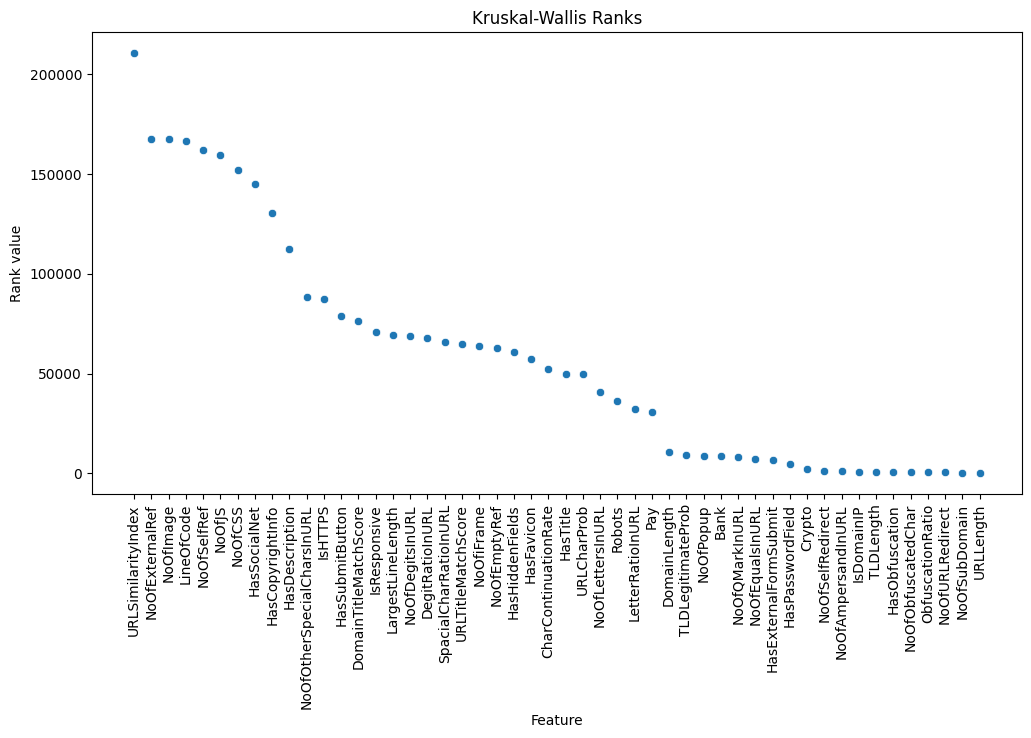

In [13]:
def plot_rank(rank):
    # Extrair os valores de rank (estatísticas de Kruskal-Wallis) e os nomes das features
    rank_values = [item[1].statistic for item in rank]
    feature_names = [item[0] for item in rank]
    
    # Criar um DataFrame com os valores de rank e os nomes das features
    rank_df = pd.DataFrame({'Feature': feature_names, 'Rank': rank_values})
    
    # Criar o gráfico de dispersão
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=rank_df, x='Feature', y='Rank')
    #plt.axhline(y=15000, color='r', linestyle='--')
    
    plt.title("Kruskal-Wallis Ranks")
    plt.ylabel("Rank value")
    plt.xlabel("Feature")
    plt.xticks(rotation=90)  # Rotacionar os rótulos das features no eixo x para melhor visualização
    plt.show()
    
plot_rank(Hs_sorted)
    

## PCA

[0.17894784 0.08953599 0.05436764 0.03994741 0.03721717 0.0360099
 0.03178323 0.02965227 0.02757545 0.02457752 0.02282579 0.02230391
 0.02132297 0.02013999 0.01999336 0.01987981 0.01943557 0.01898402
 0.01734106 0.0169964  0.01629168 0.01547228 0.01484883 0.01455484
 0.01361394 0.01326502 0.01286055 0.01232601 0.01197232 0.01157134
 0.01116381 0.01075655 0.00916345 0.00903338 0.00873388 0.00842309
 0.00784404 0.00776722 0.00661461 0.00599007 0.00561029 0.00499052
 0.00435139 0.00414616 0.00290788 0.00211145 0.00183087 0.00116959
 0.00115856 0.00061905]
    Preserved Variance
0            55.897775
1            69.891615
2            75.051293
3            77.836894
4            80.254737
5            82.518263
6            84.281610
7            85.816429
8            87.143783
9            88.198213
10           89.107694
11           89.976061
12           90.769726
13           91.477769
14           92.175541
15           92.865409
16           93.524790
17           94.153887
18  

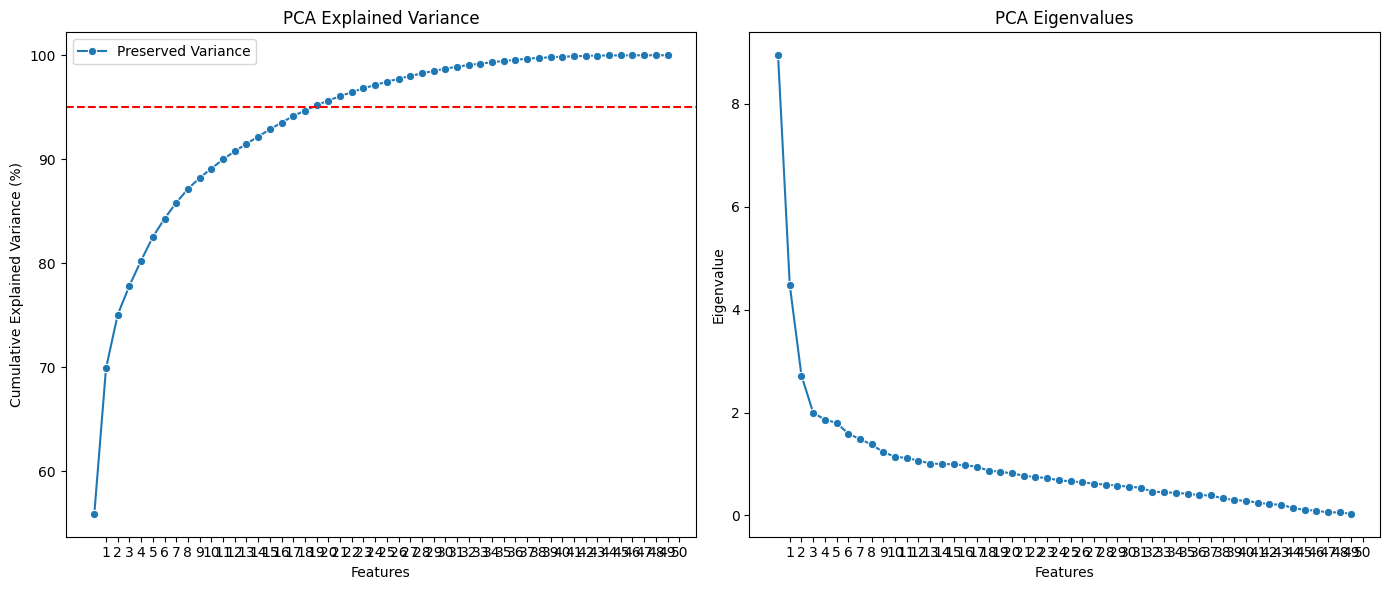

In [ ]:
def pca_function(x):
    #Fit PCA
    pca = PCA(n_components=x.shape[1])
    pca.fit(x)
    
    #Calculate the explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    #print(explained_variance_ratio)
    
    eigenvalues = pca.explained_variance_
    preserved_variance = [(eigenvalues[:i+1]**2).sum() / (eigenvalues**2).sum() * 100 for i in range(len(eigenvalues))]
    preserved_variance = pd.DataFrame(preserved_variance, columns=['Preserved Variance'])
    return pca, preserved_variance, eigenvalues

pca, preserved_variance, eigenvalues= pca_function(X)
#print(preserved_variance)

def plots_pca(preserved_variance, eigenvalues):
    #Assuming preserved_variance and eigenvalue are already defined
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    #Plot preserved variance
    sns.lineplot(ax=axes[0], data=preserved_variance, marker='o')
    axes[0].axhline(y=95, color='r', linestyle='--')
    axes[0].set_title("PCA Explained Variance")
    axes[0].set_xlabel("Features")
    axes[0].set_ylabel("Cumulative Explained Variance (%)")
    axes[0].set_xticks(range(1, len(preserved_variance) + 1))

    #Plot eigenvalues
    sns.lineplot(ax=axes[1], data=eigenvalues, marker='o')
    axes[1].set_title("PCA Eigenvalues")
    axes[1].set_xlabel("Features")
    axes[1].set_ylabel("Eigenvalue")
    axes[1].set_xticks(range(1, len(eigenvalues) + 1))

    plt.tight_layout()
    plt.show()
    
plots_pca(preserved_variance, eigenvalues)



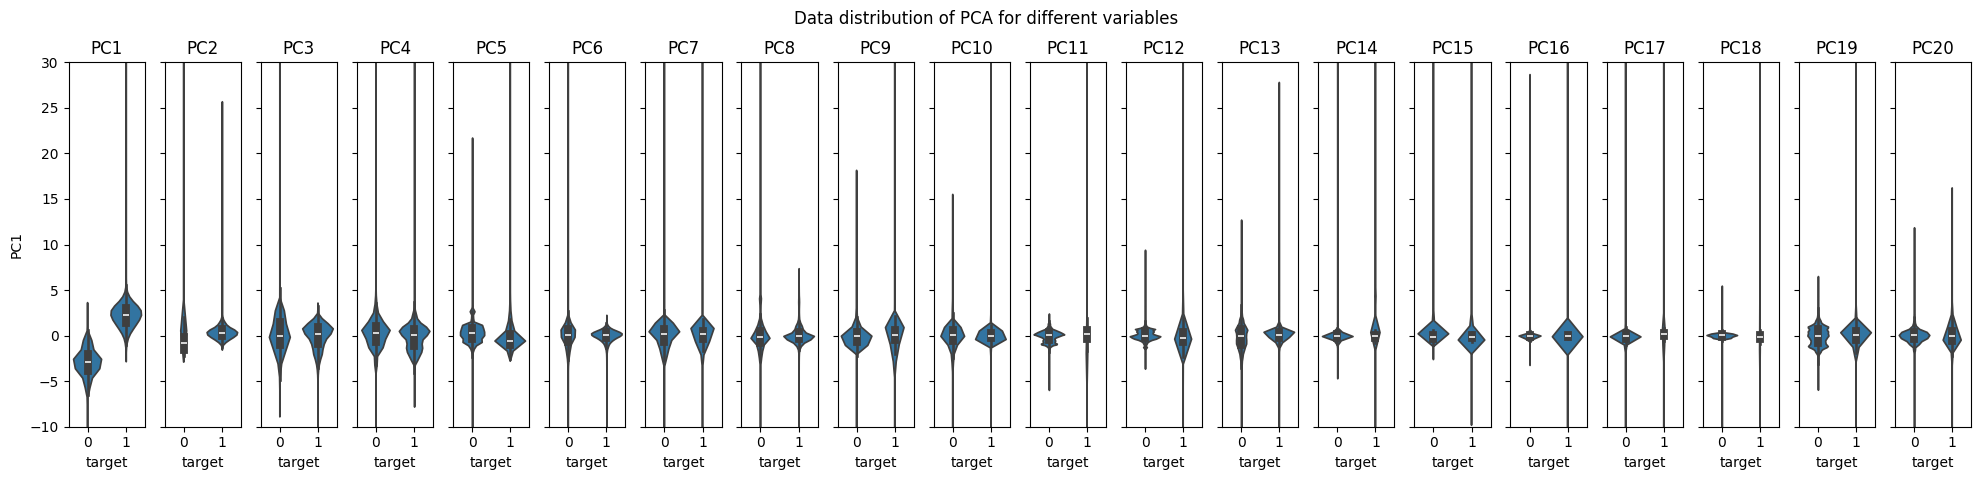

In [27]:
def plot_pca_distribution(X, y, n_components=20):
    # Fit PCA
    pca = PCA(n_components=n_components)
    x_pca = pd.DataFrame(pca.fit_transform(X), columns=[f'PC{i+1}' for i in range(n_components)])

    # Combine PCA results with target
    df = x_pca.copy()
    df['target'] = y

    # Plotting
    fig, axes = plt.subplots(1, n_components, figsize=(20, 5), sharey=True)
    for i, feature in enumerate(x_pca.columns):
        sns.violinplot(data=df, x='target', y=feature, ax=axes[i])
        axes[i].set_title(f"PC{i+1}")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.ylim(-10, 30)
    plt.suptitle("Data distribution of PCA for different variables")
    plt.show()
    return x_pca


x_pca = plot_pca_distribution(X, y)

## LDA

In [16]:
def lda(X, y, cols=None):
    
    if cols is not None:
        X = X[cols]
    
    lda = LinearDiscriminantAnalysis()
    lda.fit(X, y)
    X_lda = pd.DataFrame(lda.transform(X), columns=['Feature'])
    
    return X_lda


In [17]:
def plot_lda(X_lda, y):
    
    df = pd.DataFrame(data=X_lda, columns=['Feature'])  
    df["Class"] = y  
    
    plt.figure()
    sns.kdeplot(data=df[df['Class'] == 0]['Feature'], label="Phishing", fill=True, color='red')
    sns.kdeplot(data=df[df['Class'] == 1]['Feature'], label="Legítimo", fill=True, color='blue')
    plt.legend()
    plt.title("Distribution of LDA Projection by Class")
    plt.xlabel("LDA Feature")
    plt.ylabel("Density")
    plt.show()
    
    

## MDC

 - Euclidian Distance
 - Mahalanobis Distance

In [18]:
class MinimumDistanceClassifier:
    def __init__(self, metric="euclidean"):
        self.metric = metric
        self.centroids = {}
        self.covariances = {}

    def fit(self, X_train, y_train):
        # Calcular os centroides das classes
        self.centroids = {c: np.mean(X_train[y_train == c], axis=0) for c in np.unique(y_train)}
        if self.metric == "mahalanobis":
            # Calcular as covariâncias das classes
            self.covariances = {}
            for c in np.unique(y_train):
                class_data = X_train[y_train == c]
                if class_data.shape[0] > 1:
                    self.covariances[c] = np.cov(class_data, rowvar=False)
                else:
                    self.covariances[c] = np.eye(class_data.shape[1])  # Usar matriz identidade se não for possível calcular a covariância

    def predict(self, X_test):
        predictions = []
        for _, x in X_test.iterrows():
            if self.metric == "euclidean":
                # Calcular distâncias euclidianas
                distances = {c: np.linalg.norm(x - self.centroids[c]) for c in self.centroids}
            elif self.metric == "mahalanobis":
                # Calcular distâncias de Mahalanobis
                distances = {}
                for c in self.centroids:
                    if self.covariances[c].ndim == 2 and self.covariances[c].shape[0] > 1:
                        inv_cov = np.linalg.inv(self.covariances[c])
                    else:
                        inv_cov = np.eye(len(self.centroids[c]))  # Usar matriz identidade se a covariância não for invertível
                    distances[c] = mahalanobis(x, self.centroids[c], inv_cov)
            else:
                raise ValueError("Invalid metric. Choose 'euclidean' or 'mahalanobis'.")
            predictions.append(min(distances, key=distances.get))
        return predictions

In [19]:
def evaluate_MDC(df_X, df_y, metric="euclidean", n_runs=10, output_file=None):
    results = {
        'accuracy': [],
        'sensitivity': [],
        'specificity': []
    }
    confusion_matrices = []

    for i in range(n_runs):
        X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=i, stratify=df_y)
        
        
        # Se eu já normalizei os dados antes não preciso de fazer aqui certo? 
        

        classifier = MinimumDistanceClassifier(metric=metric)
        classifier.fit(X_train, y_train)
        predictions = classifier.predict(pd.DataFrame(X_test, columns=X_train.columns))

        tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
        results['accuracy'].append((tp + tn) / (tp + tn + fp + fn))
        results['sensitivity'].append(tp / (tp + fn))
        results['specificity'].append(tn / (tn + fp))
        confusion_matrices.append(np.array([[tn, fp], [fn, tp]]))

    results_df = pd.DataFrame(results)

    # Calcular a média e o desvio padrão das matrizes de confusão no final das 10 rondas
    confusion_matrices = np.array(confusion_matrices)
    mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
    std_confusion_matrix = np.std(confusion_matrices, axis=0)

    if output_file:
        results_df.to_csv(output_file, index=False)
        np.savez(output_file.replace('.csv', '_confusion_matrices.npz'), 
                 confusion_matrices=confusion_matrices, 
                 mean_confusion_matrix=mean_confusion_matrix, 
                 std_confusion_matrix=std_confusion_matrix)
        print(f"Results and confusion matrices saved to '{output_file}' and '{output_file.replace('.csv', '_confusion_matrices.npz')}'")

    print("Mean Confusion Matrix:")
    print(mean_confusion_matrix)
    print("Standard Deviation of Confusion Matrix:")
    print(std_confusion_matrix)

    return results_df



### Fisher LDA

- Simplesmente usamos a LDA para reduzir as variáveis e aplicamos a MDC.

In [20]:
def fisher_lda(X, y, cols=None, output_file=None):
    
    X_lda = lda(X, y, cols)
    
    plot_lda(X_lda, y)
        
    fisher_mdc_euclidean = evaluate_MDC(X_lda, y, metric="euclidean", n_runs=10, output_file= output_file +"_euclidean.csv")
    fisher_mdc_mahalanobis = evaluate_MDC(X_lda, y, metric="mahalanobis", n_runs=10, output_file= output_file +"_mahalanobis.csv")
    
    return fisher_mdc_euclidean, fisher_mdc_mahalanobis
    
    

## LDA + MDC

['URLSimilarityIndex', 'NoOfExternalRef', 'NoOfImage', 'LineOfCode', 'NoOfSelfRef', 'NoOfJS', 'NoOfCSS', 'HasSocialNet', 'HasCopyrightInfo', 'HasDescription']


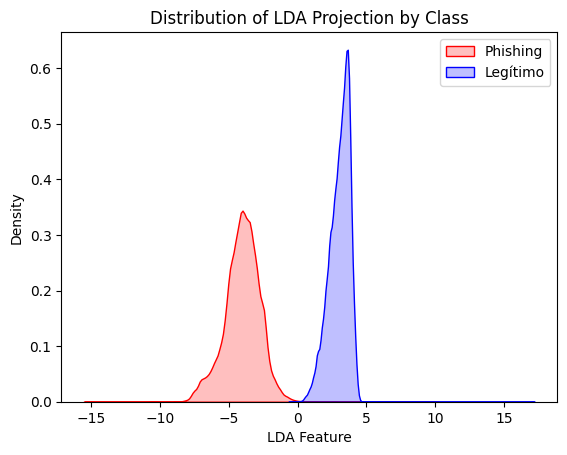

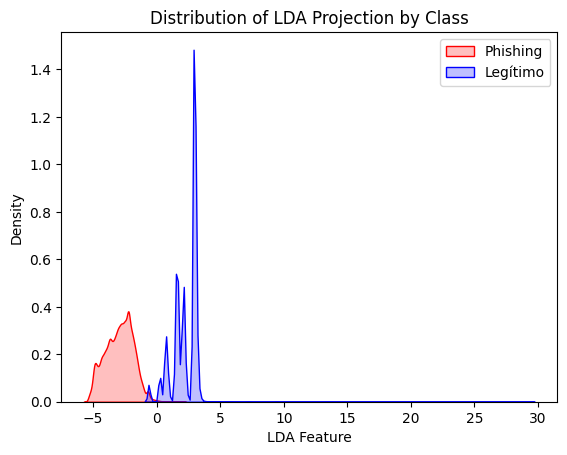

KeyboardInterrupt: 

In [28]:
cols = [x[0] for x in Hs_sorted[:10]]
print(cols)
X_lda_S_cols = lda(X, y)
X_lda_C_cols = lda(X, y, cols)

plot_lda(X_lda_S_cols, y)
plot_lda(X_lda_C_cols, y)

mdc_euclidean_LDA = evaluate_MDC(X_lda_S_cols, y, metric="euclidean", n_runs=10, output_file="results_mdc_euclidean_LDA.csv")
mdc_mahalanobis_LDA = evaluate_MDC(X_lda_S_cols, y, metric="mahalanobis", n_runs=10, output_file="results_mdc_mahalanobis_LDA.csv")
    
print("Euclidean LDA Results:")
display(mdc_euclidean_LDA.describe())

print("Mahalanobis LDA Results:")
display(mdc_mahalanobis_LDA.describe())


## LDA + Fisher LDA

- Não vale a pena aplicar esta função, uma vez que estariamos a realizar duas vezes o LDA e depois a realizar MDC. O que não faz sentido. 

## PCA + MDC

In [29]:
mdc_euclidean_PCA = evaluate_MDC(x_pca, y, metric="euclidean", n_runs=10, output_file="results_mdc_euclidean_PCA.csv")
mdc_mahalanobis_PCA = evaluate_MDC(x_pca, y, metric="mahalanobis", n_runs=10, output_file="results_mdc_mahalanobis_PCA.csv")

print("Euclidean PCA Results:")
display(mdc_euclidean_PCA.describe())

print("Mahalanobis PCA Results:")
display(mdc_mahalanobis_PCA.describe())

Results and confusion matrices saved to 'results_mdc_euclidean_PCA.csv' and 'results_mdc_euclidean_PCA_confusion_matrices.npz'
Mean Confusion Matrix:
[[19856.2   332.8]
 [  353.3 26616.7]]
Standard Deviation of Confusion Matrix:
[[11.61722859 11.61722859]
 [22.12713267 22.12713267]]
Results and confusion matrices saved to 'results_mdc_mahalanobis_PCA.csv' and 'results_mdc_mahalanobis_PCA_confusion_matrices.npz'
Mean Confusion Matrix:
[[20046.1   142.9]
 [   46.1 26923.9]]
Standard Deviation of Confusion Matrix:
[[12.36486959 12.36486959]
 [ 7.119691    7.119691  ]]
Euclidean PCA Results:


accuracy  sensitivity  specificity
count  10.000000    10.000000    10.000000
mean    0.985451     0.986900     0.983516
std     0.000575     0.000865     0.000607
min     0.984754     0.985688     0.982812
25%     0.985188     0.986402     0.983011
50%     0.985220     0.986596     0.983407
75%     0.985655     0.987458     0.983704
max     0.986471     0.988543     0.984596

Mahalanobis PCA Results:


accuracy  sensitivity  specificity
count  10.000000    10.000000    10.000000
mean    0.995992     0.998291     0.992922
std     0.000397     0.000278     0.000646
min     0.995356     0.997775     0.992124
25%     0.995754     0.998137     0.992384
50%     0.995929     0.998350     0.992917
75%     0.996263     0.998443     0.993350
max     0.996607     0.998739     0.993809

## PCA + Fisher LDA

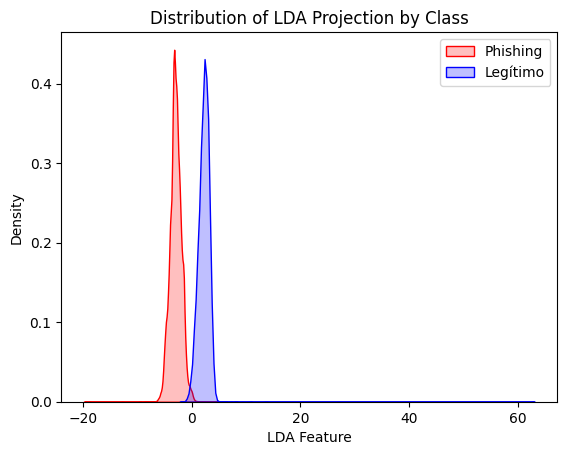

Results and confusion matrices saved to 'results_fisher_PCA_euclidean.csv' and 'results_fisher_PCA_euclidean_confusion_matrices.npz'
Mean Confusion Matrix:
[[19977.3   211.7]
 [  150.1 26819.9]]
Standard Deviation of Confusion Matrix:
[[12.08345977 12.08345977]
 [11.38815174 11.38815174]]
Results and confusion matrices saved to 'results_fisher_PCA_mahalanobis.csv' and 'results_fisher_PCA_mahalanobis_confusion_matrices.npz'
Mean Confusion Matrix:
[[19977.3   211.7]
 [  150.1 26819.9]]
Standard Deviation of Confusion Matrix:
[[12.08345977 12.08345977]
 [11.38815174 11.38815174]]
Fisher LDA + Euclidean PCA Results:


accuracy  sensitivity  specificity
count  10.000000    10.000000    10.000000
mean    0.992328     0.994435     0.989514
std     0.000426     0.000445     0.000631
min     0.991751     0.993437     0.988410
25%     0.992122     0.994327     0.989239
50%     0.992281     0.994475     0.989524
75%     0.992552     0.994726     0.989635
max     0.993214     0.994957     0.990886

Fisher LDA + Mahalanobis PCA Results:


accuracy  sensitivity  specificity
count  10.000000    10.000000    10.000000
mean    0.992328     0.994435     0.989514
std     0.000426     0.000445     0.000631
min     0.991751     0.993437     0.988410
25%     0.992122     0.994327     0.989239
50%     0.992281     0.994475     0.989524
75%     0.992552     0.994726     0.989635
max     0.993214     0.994957     0.990886

In [32]:
fisher_mdc_euclidean, fisher_mdc_mahalanobis = fisher_lda(x_pca, y, x_pca.columns, output_file="results_fisher_PCA")

print("Fisher LDA + Euclidean PCA Results:")
display(fisher_mdc_euclidean.describe())

print("Fisher LDA + Mahalanobis PCA Results:")
display(fisher_mdc_mahalanobis.describe())